### Creating superposition states associated with discretized probability distributions

#### Prerequisites
Here are a few things you should be up to speed on before we start:
 - Python fundamentals
 - Programming quantum computers using Qiskit
 - Introduction to Probability

Resources for all of these can be found [here](https://github.com/QForestCommunity/launchpad/blob/master/README.md).

#### Dependencies

We also need a couple of Python packages to build our distribution encoder:

 - [Qiskit](https://qiskit.org/)
 - [Numpy](https://numpy.org/)
 - [SciPy](https://www.scipy.org/)
 - [Matplotlib](https://matplotlib.org/)
 
#### Contributors

[Sashwat Anagolum](https://github.com/SashwatAnagolum)

#### Qiskit Package Versions

In [1]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.14.1',
 'qiskit-aer': '0.5.1',
 'qiskit-ignis': '0.3.0',
 'qiskit-ibmq-provider': '0.7.0',
 'qiskit-aqua': '0.7.0',
 'qiskit': '0.19.1'}

#### Introduction

Given a probability distribution $p$, we want to create a quantum state $|\psi\rangle$ such that
$$|\psi\rangle = \sum_{i} \sqrt{p_i} |i\rangle$$
where $|i\rangle$ represents one of an orthonormal set of states.

While we don't known when (for what kinds of distributions) we can do this, we do know that if you can efficiently integrate over a distribution classically, then we can efficiently construct a quantum state associated with a discretized version of that distribution.

It may seem kind of trivial - we can integrate over the distribution classicaly, so why not just create the mixed state shown here?
$$\sum_i p_i |i\rangle \langle i |$$

If all we needed to do was sample from the distribution, we could use this state - but then if we were efficiently integrating the distribution classicaly, say using Monte Carlo methods, we might as well sample from the classical distribution as well.

The reason we avoid generating the distribution as a mixed quantum state is that we often need to perfom further, uniquely quantum, processing on it after creation - in this case, we cannot use the mixed state apporach.

#### Encoding the distribution

If we wanted to create a $N$ region discretization, we would need $n = log N$ qubits to represent the distribution. Let's look at a super simple case to start off: $N = 2$, so $n = 1$.

We have probabilities $p_{0}^{(1)}$ and $p_1^{(1)}$, of a random variable following the distribution lying in region $0$ and region $1$, respectively, with $p^{(i)}_{j}$ representing the probability of measuring a random variable in region $j$ if it follows the discretized distribution over $i$ qubits.

Since we only use one qubit, all we need to do is integrate over region $0$ to find the probability of a variable lying within it. Let's take a quick look at the Bloch sphere:

![Bloch Sphere](./img/load_probability_distributions/bloch.png)

If a qubit is rotated about the y-axis by angle $\theta$, then the probability of measuring it as zero is given by $\cos (\frac{\theta}{2})^2$ - so we can figure out how much to rotate a qubit by if we're using it to encode a distribution:

$$ \theta = 2 * \cos^{-1} \left ( \sqrt{p_{0}^{(1)}}\right )$$

$$p_{0}^{(1)} = \int_{x^{(1)}_{0}}^{x_{1}^{(1)}}p(x) dx$$

Where $p$ is the distribution's density function, and $x^{(1)}_{0}$ and $x_{1}^{(1)}$ are the first and second region boundaries when 1 qubit is used. This leaves us with

$$|\psi \rangle = \sqrt{p_{0}^{(1)}} |0\rangle + \sqrt{p_{1}^{(1)}} |1\rangle$$
    
Awesome!

Now that we know how to do it for distributions with two regions, let's see if we can expand it to include more regions - i.e., can we convert a quantum state encoding a $N$ region discretization into one encoding a discretization with $2N$ regions?

To get started, let's avoid all the complicated integration stuff we'll need to do later by defining a function $f(i, n)$ such that

$$f(i, n) = \frac{\int_{x_{k}^{(n + 1)}}^{x_{k + 1}^{(n + 1)}} p(x) dx}{\int^{x_{i + 1}^{(n)}}_{x_{i}^{(n)}} p(x) dx}$$

Where $k = 2 * \left ( \frac{i}{2} - \frac{i \% 2}{2} \right )$. The equation above probably looks a little hopeless, but all it does it computes the conditional probability of a value lying in the left subregion of region $i$ (when we have $N$ regions), given that it lies in region $i$. 

Why do we need this?

We're assuming that dividing the distribution into $N$ regions is just an intermediary step in the process of dividing it into the desired $2^{m}$ regions - so $x_{k}^{(n + 1)}$ refers to the same boundary that $x_{i}^{(n)}$ does.

Now that we've defined $f(i, n)$, all we need to do to figure out how much to rotate the $(n + 1)^{th}$ qubit is compute

$$\theta_{i}^{(n + 1)} = 2 * \cos^{-1} \left ( \sqrt{f(i, n)}\right )$$

Now all we need to do is rotate the $(n + 1)^{th}$ qubit by $\theta_{i}^{(n + 1)}$ conditioned on the state $|i\rangle$ represented using $n$ qubits:

$$\sqrt{p_{i}^{(n)}}|i\rangle \rightarrow \sqrt{p^{(n + 1)}_{k}}|k\rangle + \sqrt{p^{(n + 1)}_{k + 1}}|k+1\rangle$$

Since we showed that constructing a state for $n = 1$ was possible, and given a $2^n$ region discretization, we could convert into a distribution with $2^{(n + 1)}$ regions, we just inductively proved that we can construct a superposition state corresponding to a $2^n, n \in \mathbb{N}$ region discretized distribution - pretty cool!

Now that we've gotten the concepts down, let's move on to building our own quantum distribution encoder.

#### Required modules

In [2]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import Aer, execute, QuantumCircuit
from qiskit.circuit.library.standard_gates import RYGate
from numpy import pi, e, sqrt, arccos, log2
from scipy.integrate import quad
%matplotlib inline
import matplotlib.pyplot as plt

Let's define a function representing our distribution, so that we can change super quickly whenever we want to. We'll start off with a super simple function, like $N(0, 2)$:

In [3]:
def distribution(x):
    """
    Returns the value of a chosen probability distribution at the given value
    of x. Mess around with this function to see how the encoder works!

    The current distribution being used is N(0, 2).
    """
    # Use these with normal distributions
    mu = 0
    sigma = 2
    return (((e ** (-0.5 * ((x - mu) / sigma) ** 2)) / (sigma * sqrt(2 * pi))) / 0.99993665)

The 0.99993665 is a normalisation factor used to make sure the sum of probabilities over the regions we've chosen adds up to 1.

Next, let's create everything else we need to compute $f(i, n)$:

In [4]:
def integrate(dist, lower, upper):
    """
    Perform integration using numpy's quad method. We can use parametrized
    distributions as well by using this syntax instead:
    quad(integrand, lower, upper, args=(tupleOfArgsForIntegrand))
    """
    return quad(dist, lower, upper)[0]

In [5]:
def computeRegionProbability(dist, regBounds, numRegions, j):
    """
    Given a distribution dist, a list of adjacent regions regBounds, the
    current level of discretization numRegions, a region number j, computes
    the probability that the value random variable following dist lies in
    region j given that it lies in the larger region made up of regions
    [(j // 2) * 2, ((j + 2) // 2) * 2]
    """
    totalRegions = len(regBounds) - 1
    k = 2 * j

    prob = integrate(dist, regBounds[(totalRegions // numRegions) * k],
        regBounds[(totalRegions // numRegions) * (k + 1)]) / integrate(
        dist, regBounds[(totalRegions // numRegions) * ((k // 2) * 2)],
        regBounds[(totalRegions // numRegions) * (((k + 2) // 2) * 2)])

    return prob

$computeRegionProbability$ gives us the value of $f(i, n)$. We're finally ready to start writing the quantum part of our program - let's start by creating the registers and circuit we need:

In [ ]:
def encodeDist(dist, regBounds):
    numQubits = int(log2(len(regBounds) - 1))

    a = QuantumRegister(2 * numQubits - 2)
    c = ClassicalRegister(numQubits)
    qc = QuantumCircuit(a, c)

Now we can create the looping construct we need to be able to iteratively divide the distribution into $2^m$ regions, starting from $n = 1$ ($2$ regions), and dividing until $n = log N$ ($N$ regions). We need to loop over the different regions in the current , and compute the value of $f(i, n)$ for each one:

In [ ]:
    for i in range(numQubits):
        numRegions = int(2 ** (i + 1))

        for j in range(numRegions // 2):
            prob = computeRegionProbability(dist, regBounds, numRegions, j)

Now we need to apply the controlled rotations - but we also need to write in a special case for $n = 1$, because there are no qubits to condition the rotation on:

In [ ]:
            if not i:
                qc.ry(2 * arccos(sqrt(prob)), a[2 * numQubits - 3])

Since we'll be using gates with an arbitrary number of control qubits, we use the ControlledGate:

In [ ]:
            else:
                cGate = RYGate(2 * arccos(sqrt(prob))).control(i)

We know that we need to use the qubits indexed by $[0, 1, ..., i - 1]$ as control qubits, and the $n^{th}$ one as the target - but before we can apply the gate we need to perform a few bit flips to make sure that the $n^{th}$ qubit is rotated only when the control qubits are in the state $|i\rangle$. We can figure out which qubits to flip using this function:

In [6]:
def getFlipList(i, j, numQubits):
    """
    Given the current level of desired level of discretization, the
    current level of discretization i and a region number j,
    returns the binary bit string associated with j in the form of
    a list of bits to be flipped.
    """
    binString = str(bin(j))[2:]
    binString = ("0" * (numQubits - len(binString))) + binString
    bitFlips = []

    for k in range(numQubits - i, numQubits):
        if binString[k] == '0':
            bitFlips.append(3 * numQubits - 3 - k - i)

    return bitFlips

Here the variable j represents the region number, which we convert to binary, and then flip qubits so that the resulting binary string is all ones. After finding out which qubits we need to flip, we can create a controlled gate and append it to the quantum circuit back in $encodeDist$:

In [ ]:
                for k in listOfFlips:
                    qc.x(a[k])

                qubitsUsed = [a[k] for k in
                    range(2 * numQubits - 2 - i, 2 * numQubits - 2)]

                qubitsUsed.append(a[2 * numQubits - 3 - i])
                qc.append(cGate, qubitsUsed)

                for k in listOfFlips:
                    qc.x(a[k])

All that's left is to return the quantum circuit:

In [ ]:
    return qc, a, c

Here's the entire function, so that we can run it in the notebook:

In [7]:
def encodeDist(dist, regBounds):
    """
    Discretize the distribution dist into multiple regions with boundaries
    given by regBounds, and store the associated quantum superposition
    state in a new quantum register reg. Please make sure the number of 
    regions is a power of 2, i.e. len(regBounds) = (2 ** n) + 1.

    Additionally, the number of regions is limited to a maximum of
    2^(n // 2 + 1), where n is the number of qubits available in the backend
    being used - this is due to the requirement of (n - 2) ancilla qubits in
    order to perform (n - 1) control operations with minimal possible depth.

    Returns a new quantum circuit containing the instructions and registers
    needed to create the superposition state, along with the size of the
    quantum register.
    """    
    numQubits = int(log2(len(regBounds) - 1))

    a = QuantumRegister(2 * numQubits - 2)
    c = ClassicalRegister(numQubits)
    qc = QuantumCircuit(a, c)

    for i in range(numQubits):
        numRegions = int(2 ** (i + 1))

        for j in range(numRegions // 2):
            prob = computeRegionProbability(dist, regBounds, numRegions, j)

            if not i:
                qc.ry(2 * arccos(sqrt(prob)), a[2 * numQubits - 3])
            else:
                cGate = RYGate(2 * arccos(sqrt(prob))).control(i)
                listOfFlips = getFlipList(i, j, numQubits)

                for k in listOfFlips:
                    qc.x(a[k])

                qubitsUsed = [a[k] for k in
                    range(2 * numQubits - 2 - i, 2 * numQubits - 2)]

                qubitsUsed.append(a[2 * numQubits - 3 - i])
                qc.append(cGate, qubitsUsed)

                for k in listOfFlips:
                    qc.x(a[k])

    return qc, a, c

Finally, we can call our function, and compare the results with those from a classical computer - we also need a helper function that pads bit strings for us, so that we can plot the classical results on the same axis as the quantum ones:

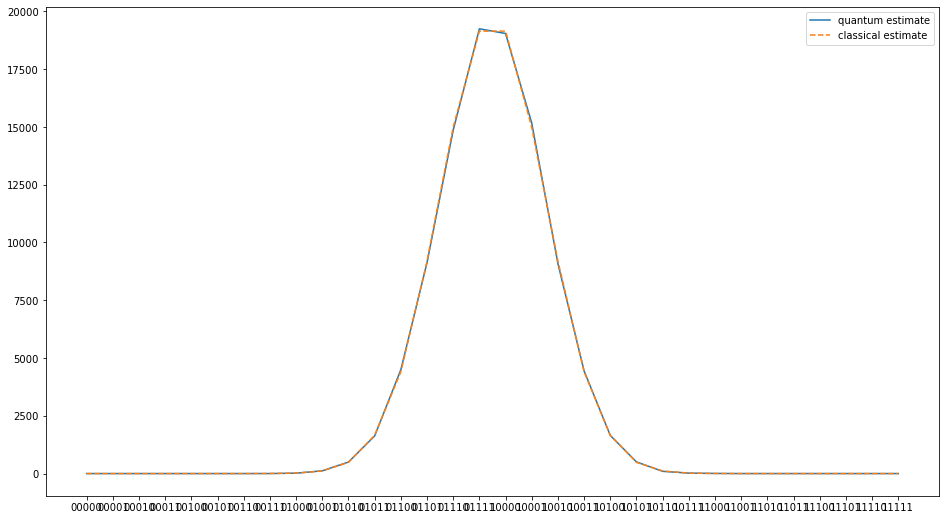

In [8]:
def pad(x, numQubits):
    """
    Utility function that returns a left padded version of the bit string
    passed.
    """
    string = str(x)[2:]
    string = ('0' * (numQubits - len(string))) + string
    return string

regBounds = [i for i in range(-16, 17)]
qc, a, c = encodeDist(distribution, regBounds)
numQubits = (qc.num_qubits + 2) // 2

for i in range(numQubits - 2, 2 * numQubits - 2):
    qc.measure(a[i], c[i - (numQubits - 2)])

backend = Aer.get_backend('qasm_simulator')
shots = 100000
job = execute(qc, backend=backend, shots=shots)
results = job.result().get_counts()
resultsX = []
resultsY = []

for i in [pad(bin(x), numQubits) for x in range(2 ** (numQubits))]:
    resultsX.append(i)
    if i in results.keys():
        resultsY.append(results[i])
    else:
        resultsY.append(0)

truthDisc = [integrate(distribution, regBounds[i], regBounds[i + 1]) * shots for i in range(
    len(regBounds) - 1)]

plt.figure(figsize=[16, 9])
plt.plot(resultsX, resultsY)
plt.plot(resultsX, truthDisc, '--')
plt.legend(['quantum estimate', 'classical estimate'])
plt.show()

#### Things to do next
Looks like we're done - awesome!

Taking all the functions from this notebook and pasting them into a python file will give you a working copy of this program, provided you have all the dependencies installed - if you want a regular python file instead, you can get a copy [here](https://github.com/SashwatAnagolum/DoNew/blob/master/loadProbDist/loadProbDist.py).

A possible next step after getting the hang of encoding distributions is to figure out ways to process the quantum state further, leading to purely quantum transformed versions of the distribution.

Let me know if you figure out any other ways we can work with the quantum state we get using this circuit, or if you have any other questions - you can reach me at [sashwat.anagolum@gmail.com](mailto:sashwat.anagolum@gmail.com)